## **Finding Lane Lines on the Road** 
***
In this project, I will use the OpenCV & Python to identify lane lines on the road. Firstly, I can develop the pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

---
**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


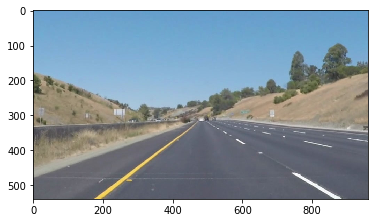

In [6]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

In [7]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

**Make sure pipeline works well on these images before try the videos.**

In [8]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


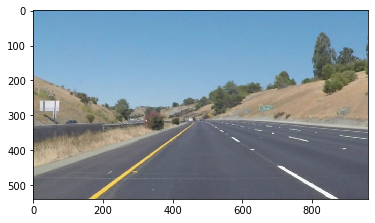

In [9]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Build a Lane Finding Pipeline



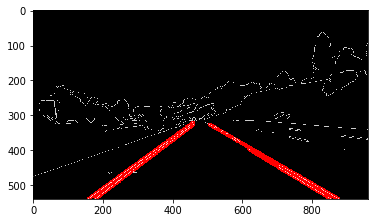

In [46]:
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 9
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 100
edges = canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()  

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 #minimum number of pixels making up a line
max_line_gap = 250   # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

True

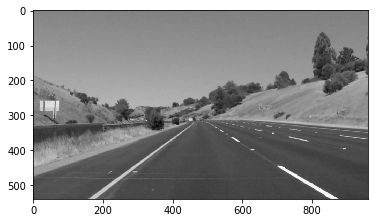

In [47]:
plt.imshow(gray,cmap='gray')
cv2.imwrite('test_images_output/gray.jpg', gray)

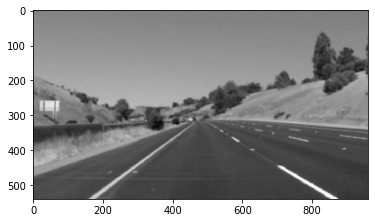

In [48]:
plt.imshow(blur_gray,cmap='gray')

True

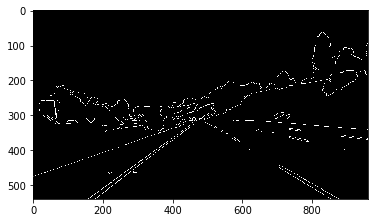

In [49]:
plt.imshow(edges,cmap='gray')
cv2.imwrite('test_images_output/edges.jpg', edges)

In [50]:
vertices

array([[[  0, 540],
        [450, 320],
        [490, 320],
        [960, 540]]], dtype=int32)

True

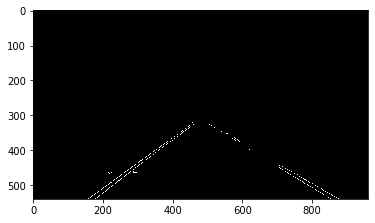

In [51]:
plt.imshow(masked_edges,cmap='gray')
cv2.imwrite('test_images_output/edges.jpg', masked_edges)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


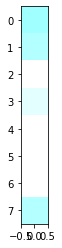

In [57]:
plt.imshow(lines)

In [54]:
lines

array([[[160, 538, 460, 320]],

       [[179, 538, 460, 326]],

       [[701, 448, 851, 538]],

       [[228, 500, 460, 325]],

       [[516, 332, 874, 538]],

       [[506, 327, 873, 539]],

       [[619, 398, 852, 538]],

       [[180, 538, 458, 328]]], dtype=int32)

True

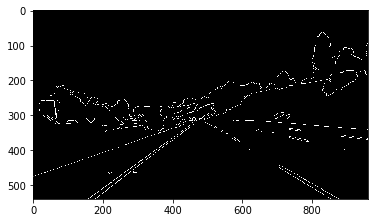

In [55]:
plt.imshow(color_edges)
cv2.imwrite('test_images_output/edges.jpg', color_edges)

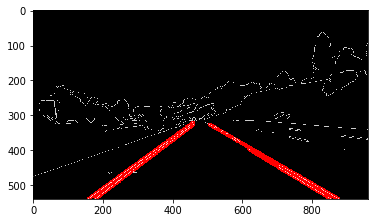

In [56]:
plt.imshow(lines_edges)

In [95]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 9)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 30, 90)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 50, 10, 200)
    
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)


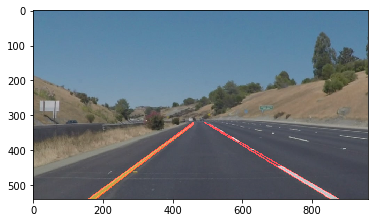

In [96]:
out_image = process_image(image)
plt.imshow(out_image)

In [97]:
cv2.imwrite('test_images_output/solidYellowCurve2.jpg', out_image)    # to save the image

True

## Test on Videos

I can test my solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```

In [98]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


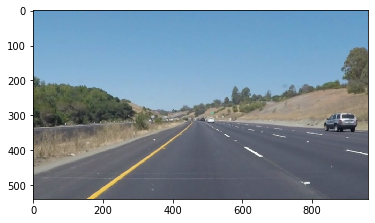

In [99]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [137]:
# # NOTE: The output you return should be a color image (3 channel) for processing video below
# def process_image(image):

#     # grayscale conversion before processing causes more harm than good
#     # because sometimes the lane and road have same amount of luminance
#     # grayscaleImage = grayscale(image)

#     # Blur to avoid edges from noise
#     blurredImage = gaussian_blur(image, 5)
    
#     # Detect edges using canny
#     # high to low threshold factor of 3
#     # it is necessary to keep a linient threshold at the lower end
#     # to continue to detect faded lane markings
#     edgesImage = canny(blurredImage, 50, 100)
    
#     # mark out the trapezium region of interest
#     # dont' be too agressive as the car may drift laterally
#     # while driving, hence ample space is still left on both sides.
#     height = image.shape[0]
#     width = image.shape[1]
#     vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
#     # mask the canny output with trapezium region of interest
#     regionInterestImage = region_of_interest(edgesImage, vertices)
    
#     # parameters tuned using this method:
#     # threshold 30 by modifying it and seeing where slightly curved 
#     # lane markings are barely detected
#     # min line length 20 by modifying and seeing where broken short
#     # lane markings are barely detected
#     # max line gap as 100 to allow plenty of room for the algo to 
#     # connect spaced out lane markings
#     lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 50, 100, 160)
    
#     # Test detected edges by uncommenting this
#     # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

#     # draw output on top of original
#     return weighted_img(lineMarkedImage, image)



In [138]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 9)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 30, 90)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 50, 10, 200)
    
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)


Let's try the one with the solid white lane on the right first ...

In [139]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## Uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 6/221 [00:00<00:03, 58.04it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 10.7 s, sys: 2.59 s, total: 13.3 s
Wall time: 8.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [140]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [141]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## Uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 6/681 [00:00<00:11, 59.20it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 33.7 s, sys: 7.61 s, total: 41.3 s
Wall time: 25.3 s


In [142]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))